## DETERMINING HABITABLE ZONES ##

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from astropy import constants as const
from astropy import units as u
import pylab as py
import statsmodels.api as sm
# DEFYNING CONSTANTS
# Definiendo constantes
G = const.G.to(u.cm**3/(u.g*u.s**2)) # Constante Gravitacional en cm^3/(g*s^2)
Msol = const.M_sun.to(u.g) # Masa solar en gramos
R_sol = const.R_sun.to(u.cm)  # Radio del sol en centímetros

In [76]:
# Read the CSV file with space as the delimiter
exoplanet_data_ = pd.read_csv('exoplanet_data.csv', sep=',', comment='#')
exoplanet_data = exoplanet_data_[['Planet_name', 'Host_name', 'Number_of_stars', 
                                'Number_of_planets', 'Number_of_moons', 
                                'Orbital_period[days]', 'Orbit_semimajor_axis', 'Planet_radius[Earth]',
                                'Planet_mass[Earth]', 'Planet_density[g/cm^3]','Orbit_eccentricity',
                                'Planet_equilibrium_temperature[K]', 'Spectral_type','Stellar_effective_temperature',
                                'Stellar_radius', 'Stellar_mass','Stellar_luminocity[log(sun)]'

                                ]]
exoplanet_data


,Planet_name,Host_name,Number_of_stars,Number_of_planets,Number_of_moons,Orbital_period[days],Orbit_semimajor_axis,Planet_radius[Earth],Planet_mass[Earth],Planet_density[g/cm^3],Orbit_eccentricity,Planet_equilibrium_temperature[K],Spectral_type,Stellar_effective_temperature,Stellar_radius,Stellar_mass,Stellar_luminocity[log(sun)]
0,K2-111 b,K2-111,1,2,0,5.351800,0.056500,1.820000,5.580,5.00,0.100,1309,G2,5775.0,1.250000,0.840000,0.27875
1,TOI-1695 b,TOI-1695,1,1,0,3.134279,0.033548,1.900000,6.360,5.00,0.097,698,M1 V,3690.0,0.515000,0.513000,-1.35360
2,K2-170 b,K2-170,1,2,0,7.576544,0.074500,1.418175,2.600,5.01,0.000,919.7,G3,5748.0,0.981614,0.963657,0.07170
3,Kepler-1038 c,Kepler-1038,1,2,0,7.127660,0.069200,1.416234,2.590,5.01,0.000,784,G8V,5159.0,0.821000,0.868000,-0.36200
4,Kepler-1398 b,Kepler-1398,1,2,0,2.788157,0.039090,0.900000,0.666,5.02,0.000,1510,G0,6126.0,1.180000,1.130000,0.31211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,Kepler-99 b,Kepler-99,2,1,0,4.603580,0.050710,1.480000,6.150,10.90,0.000,810,K3,4782.0,0.730000,0.790000,-0.58545
701,HIP 29442 d,HD 42813,1,3,0,6.429575,0.067300,1.538000,5.140,11.00,0.000,920,K0,5289.0,0.980000,0.901000,-0.15490
702,TOI-1467 b,TOI-1467,1,1,0,5.971147,0.050748,1.920000,9.000,11.00,0.000,506.07,M0,3834.0,0.491000,0.489000,-1.42022
703,EPIC 201595106 b,EPIC 201595106,1,2,0,0.877240,0.017700,1.565000,7.670,11.10,0.000,2038,G3V,5679.0,0.980000,0.958000,-0.04915


## Calculando zonas de habitabilidad 

Basándonos en el modelo de  (Kopparapu,2013), el cual considera planetas rocosos que tienen una masa menor a $5M_{\oplus}$,donde se asumen atmósferas dominadas por $H_2O$ para el límite interno y $CO{-1}_2$ para el límite externo. 
Este modelo es un modelo unidimensional, en donde se asume la atmósfera como capas, apiladas unas sobre otras. En el modelo planteado por los autores, se ignoran factores como las nubes y se concentran en como el calor se mueve a través de la atmósfera por radiación(proveniente del sol) y la convección, producto del aumento del aire caliente. 
Para este modelo se tuvieron en cuenta los siguientes casos: 1. Toman un planeta fijo y estudian el efecto de los gases no condensables($N_2$) en los límites de la ZH, variando la presión parcial de $N_2$; 2 Fijar una presión debida al $N_2$ de 0.01 bar para distintas masas de planetas entre el intervalo ya mencionado, con el fin de estudiar el efecto de la gravedad por sí solo, y 3 la presión del $N_2$ se ajusta de acuerdo al tamaño del radio del planeta y verificar el efecto del tamaño del planeta en la abundancia volátil.



# MÉTODO 
En el artículo mencionado, se tomaron temperaturas efectivas entre $2500 k\leq T_eff \leq 7200 k$. Para esta primera parte se tomarán los planetas dentro del rango de masa y se tomarán únicamente aquellos planetas cuya estrella sea de secuencia principal.

In [77]:
# # Obtaining plaets with Mass between 0.4 to 5 
# kopparapu = exoplanet_data[
#     (exoplanet_data['Planet_mass[Earth]'] >= 0.4) & 
#     (exoplanet_data['Planet_mass[Earth]'] <= 10.5)
# ]

# kopparapu

In [78]:
main_stars = exoplanet_data[exoplanet_data['Spectral_type'].str.contains('V', na = False) & 
                            ~exoplanet_data['Spectral_type'].str.contains('I', na = False)].dropna()

main_stars

,Planet_name,Host_name,Number_of_stars,Number_of_planets,Number_of_moons,Orbital_period[days],Orbit_semimajor_axis,Planet_radius[Earth],Planet_mass[Earth],Planet_density[g/cm^3],Orbit_eccentricity,Planet_equilibrium_temperature[K],Spectral_type,Stellar_effective_temperature,Stellar_radius,Stellar_mass,Stellar_luminocity[log(sun)]
1,TOI-1695 b,TOI-1695,1,1,0,3.134279,0.033548,1.900000,6.360,5.000000,0.09700,698,M1 V,3690.0,0.5150,0.5130,-1.35360
3,Kepler-1038 c,Kepler-1038,1,2,0,7.127660,0.069200,1.416234,2.590,5.010000,0.00000,784,G8V,5159.0,0.8210,0.8680,-0.36200
7,TOI-836 b,TOI-836,1,2,0,3.816730,0.042200,1.704000,4.530,5.020000,0.05300,871,K V,4552.0,0.6650,0.6780,-0.85276
8,TRAPPIST-1 f,TRAPPIST-1,1,7,0,9.207540,0.038490,1.045000,1.039,5.022904,0.01007,217.7,M8 V,2566.0,0.1192,0.0898,-3.25727
10,Kepler-1759 b,Kepler-1759,1,1,0,3.720230,0.042900,0.903779,0.676,5.030000,0.00000,954,K2V,5017.0,0.7970,0.7600,-0.56331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,KOI-3503 b,KOI-3503,1,2,0,21.185000,0.142470,1.190000,9.200,10.000000,0.00000,785,F9/G0V,6001.0,1.2550,0.8580,0.30005
693,KOI-3503 c,KOI-3503,1,2,0,31.828000,0.186880,1.210000,10.360,10.000000,0.00000,686,F9/G0V,6001.0,1.2550,0.8580,0.30005
695,Kepler-105 c,Kepler-105,1,2,0,7.125920,0.072290,1.440000,5.600,10.400000,0.02000,997,G1V,5933.0,1.0260,0.9910,0.09657
698,LHS 1678 c,LHS 1678,2,3,0,3.694284,0.032700,0.941000,1.400,10.600000,0.03900,510.9,M2.0 V,3490.0,0.3290,0.3450,-1.83863


Para conocer las distancias de los límites de la zona habitable para cada tipo de estrella, se considera la siguiente ecuación paramétrica
$ S_{eff} = S_{eff\odot } + aT_{*} + bT_{*}^2 + cT_{*}^3 + dT_{*}^4$
donde $T_{*} = T_{eff}-5780k.$
Para ello, se toman los parámetros del código proporcionado por kopparu entre 0.1M y 5 M % No sé si entonces añadir planetas de 0.1 porque me tardaría muchooooo

In [79]:
hzdat = open('HZs.csv', 'w')
# Creating a function for the effective flux 
def Kopparapu_flux (a, b, c, d, t, S_eff_sun):

    return S_eff_sun + a*t + b*t**2 + c * t**3 + d * t**4

In [80]:

# S_eff_sun = [Recent_venus, Runaway_Greenhouse,Maximum_greenhouse, Early_Mars, 0.1M Runaway_Greenhouse, 5M Runwa]
Columnas = ['Limite','S_eff_Sun', 'a', 'b', 'c', 'd']
HZ_coefficients = pd.DataFrame(columns = Columnas)
S_eff_sun = [1.776,1.107, 0.356, 0.320]
T_eff = pd.to_numeric(main_stars['Stellar_effective_temperature'])
T = T_eff - 5780 # Se toma como temperatura del sol 5780k
#Calculating coefficients 
l = ['Recent_Venus','Runaway_Greenhouse','Max_Greenhouse','Early_Mars']
a = [2.136e-4, 1.332e-4, 6.171e-5, 5.547e-5]
b = [2.533e-8, 1.580e-8, 1.698e-9, 1.526e-9]
c = [-1.332e-11, -8.308e-12, -3.198e-12, -2.874e-12]
d = [-3.097e-15, -1.931e-15, -5.575e-16, -5.011e-16]
for i in range(len(a)):
    HZ_coefficients.loc[i] = [l[i],S_eff_sun[i],a[i],b[i],c[i],d[i]]
  
HZ_coefficients.drop(columns = 'Limite')
HZ_coefficients

,Limite,S_eff_Sun,a,b,c,d
0,Recent_Venus,1.776,0.000214,2.533000e-08,-1.332000e-11,-3.097000e-15
1,Runaway_Greenhouse,1.107,0.000133,1.580000e-08,-8.308000e-12,-1.931000e-15
2,Max_Greenhouse,0.356,0.000062,1.698000e-09,-3.198000e-12,-5.575000e-16
3,Early_Mars,0.320,0.000055,1.526000e-09,-2.874000e-12,-5.011000e-16


In [81]:
# Definiendo las variables para los límites 
recentVenus_coeff = HZ_coefficients[HZ_coefficients['Limite'] == 'Recent_Venus'] 
runawayGreenhouse_coeff = HZ_coefficients[HZ_coefficients['Limite'] == 'Runaway_Greenhouse']
maxGreenhouse_coeff = HZ_coefficients[HZ_coefficients['Limite'] == 'Max_Greenhouse']
earlyMars_coeff = HZ_coefficients[HZ_coefficients['Limite'] == 'Early_Mars']


In [82]:
recentVenus = []
runawayGreenhouse = []
maxGreenhouse = []
earlyMars = []

S_eff = pd.DataFrame(index=T, columns=l, dtype=float)
S = np.zeros_like(a)

In [83]:
#Calculating the effective flux for each limit 
for t in T:
    for i in range(4):
        S_eff.loc[t, l[i]] = Kopparapu_flux(
            HZ_coefficients.iloc[i]['a'],
            HZ_coefficients.iloc[i]['b'], 
            HZ_coefficients.iloc[i]['c'],
            HZ_coefficients.iloc[i]['d'],
            t,
            HZ_coefficients.iloc[i]['S_eff_Sun']
        )
S_eff = S_eff.sort_values('Stellar_effective_temperature').reset_index()
#S_eff['Recent_Venus'][1:]
S_eff

,Stellar_effective_temperature,Recent_Venus,Runaway_Greenhouse,Max_Greenhouse,Early_Mars
0,-3214.0,1.462902,0.911885,0.221890,0.199430
1,-2880.0,1.476051,0.920049,0.230398,0.207083
2,-2873.0,1.476276,0.920188,0.230578,0.207245
3,-2827.0,1.477721,0.921085,0.231761,0.208309
4,-2827.0,1.477721,0.921085,0.231761,0.208309
...,...,...,...,...,...
158,221.0,1.824292,1.137115,0.369685,0.332301
159,224.0,1.824960,1.137531,0.369871,0.332468
160,224.0,1.824960,1.137531,0.369871,0.332468
161,224.0,1.824960,1.137531,0.369871,0.332468


In [84]:
S_eff.iloc[1]

Stellar_effective_temperature   -2880.000000
Recent_Venus                        1.476051
Runaway_Greenhouse                  0.920049
Max_Greenhouse                      0.230398
Early_Mars                          0.207083
Name: 1, dtype: float64

In [85]:
def LOWESS(x,y,frac):
    lowess_collection = pd.DataFrame(index=l)
    lowess_collection['lowess_data'] = None  # Initializes with dtype=object

    for i in l:
        lowess_df = pd.DataFrame(
            sm.nonparametric.lowess(x[i], y, frac),
            columns=['x', 'y_smooth']
        )
        # Assign mini-DataFrame as a single object inside the cell
        lowess_collection.at[i, 'lowess_data'] = lowess_df
    return lowess_collection
LOWESS(S_eff,T_eff,0.6)

,lowess_data
Recent_Venus,x y_smooth 0 2566.0 1.505816 1 ...
Runaway_Greenhouse,x y_smooth 0 2566.0 0.938559 1 ...
Max_Greenhouse,x y_smooth 0 2566.0 0.254002 1 ...
Early_Mars,x y_smooth 0 2566.0 0.228309 1 ...


In [86]:
s_c=LOWESS(S_eff,T_eff,0.6)
s_c['lowess_data'][2]['x']

/tmp/ipykernel_27369/3703139107.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s_c['lowess_data'][2]['x']


0      2566.0
1      2900.0
2      2907.0
3      2953.0
4      2953.0
        ...  
158    6001.0
159    6004.0
160    6004.0
161    6004.0
162    6040.0
Name: x, Length: 163, dtype: float64

/tmp/ipykernel_27369/3167918730.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(s_c['lowess_data'][0]['y_smooth'], s_c['lowess_data'][0]['x'],
/tmp/ipykernel_27369/3167918730.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(s_c['lowess_data'][1]['y_smooth'], s_c['lowess_data'][1]['x'],
/tmp/ipykernel_27369/3167918730.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(s_c['lowess_data'][2]['y_smooth

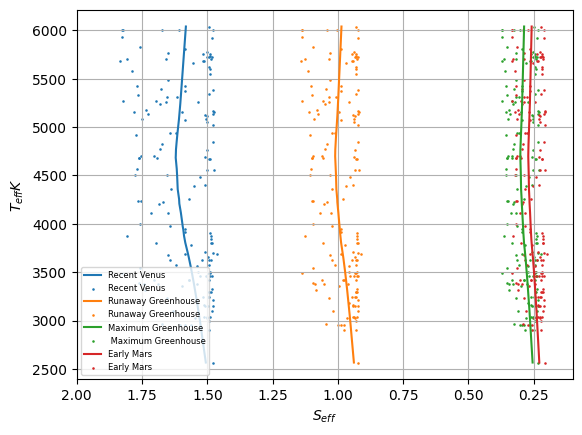

In [87]:
#modelo kopparapu

plt.plot(s_c['lowess_data'][0]['y_smooth'], s_c['lowess_data'][0]['x'],
          label = 'Recent Venus')
plt.scatter(S_eff['Recent_Venus'], T_eff, label = 'Recent Venus', s = 0.7)
plt.plot(s_c['lowess_data'][1]['y_smooth'], s_c['lowess_data'][1]['x'],
          label = 'Runaway Greenhouse')
plt.scatter(S_eff['Runaway_Greenhouse'], T_eff, label = 'Runaway Greenhouse', s=0.7)
plt.plot(s_c['lowess_data'][2]['y_smooth'], 
         s_c['lowess_data'][2]['x'], label = 'Maximum Greenhouse')
plt.scatter(S_eff['Max_Greenhouse'], T_eff, label = ' Maximum Greenhouse', s= 0.7)
plt.plot(s_c['lowess_data'][3]['y_smooth'], 
         s_c['lowess_data'][3]['x'], label = 'Early Mars')
plt.scatter(S_eff['Early_Mars'], T_eff, label = 'Early Mars', s = 0.7)
plt.xlabel(r'$S_{eff}$')
plt.gca().invert_xaxis()
plt.xlim(2,0.1)
plt.ylabel(r'$T_{eff} K$')
plt.legend(loc='lower left', fontsize=6)
plt.grid(True)
plt.savefig('/home/mavegac/Tesis/Template-Tesis/imágenes/Flujo_efectivo.pdf')
plt.show()


In [88]:
T_eff.min()

np.float64(2566.0)

In [89]:
#sample_RecentVenus = S_eff['Recent_Venus'].apply(lambda x: set_to_median(x, bin_intervals))

 Ahora bien para calcular las distancias de los límites de la HZ se utilza la siguiente ecuación

$d=\sqrt{\frac{L/L_{\odot}}{S_{eff}}} AU$
Ahora bien, la luminosidad esta dada por, donde $R_{*}$ es el radio de la estrella y T su temperatura, $R_{\odot}$ el radio del sol y $T_{\odot}= 5780$la temperatura del sol. $\sigma$ es la constante de Boltzmann 
$L = 4\pi  R_{*}^{2} \sigma  T^{4}$   
Entonces al remplazar $L$ y $L_{\odot }$ en la ecuación de $d$. 
$d =\sqrt{\frac{4\pi R_{*}^{2}\sigma  T^{4}/ 4\pi R_{\odot}^{2}\sigma T_{\odot}^{4}}{S_{eff}}} =\sqrt{\frac{R_{*}^{2} T^{4}/R_{\odot }^{2}  T_{\odot}^{4} }{S_eff}} AU$

In [90]:
T_sun = 5780 
# Calculating distances 
def distancia(T_eff,R, S_eff,T_sun):
    d = np.sqrt(((R**2*T_eff**4/ (T_sun**4))/S_eff))
    return d #Los radios solares ya estan en radios solares 

In [91]:
T_eff

1      3690.0
3      5159.0
7      4552.0
8      2566.0
10     5017.0
        ...  
692    6001.0
693    6001.0
695    5933.0
698    3490.0
703    5679.0
Name: Stellar_effective_temperature, Length: 163, dtype: float64

In [92]:
R = main_stars['Stellar_radius']

R

1      0.5150
3      0.8210
7      0.6650
8      0.1192
10     0.7970
        ...  
692    1.2550
693    1.2550
695    1.0260
698    0.3290
703    0.9800
Name: Stellar_radius, Length: 163, dtype: float64

In [93]:
T_eff.iloc[2]
l

['Recent_Venus', 'Runaway_Greenhouse', 'Max_Greenhouse', 'Early_Mars']

In [94]:
d = pd.DataFrame(index= range(len(T_eff)), columns=l)
d

,Recent_Venus,Runaway_Greenhouse,Max_Greenhouse,Early_Mars
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
158,NaN,NaN,NaN,NaN
159,NaN,NaN,NaN,NaN
160,NaN,NaN,NaN,NaN
161,NaN,NaN,NaN,NaN


In [95]:
R.iloc[0]**2 * T_eff.iloc[0]**4 * S_eff.iloc[0]['Recent_Venus']*T_sun

np.float64(4.157795525295236e+17)

In [96]:
d_1=distancia(T_eff.iloc[50],R.iloc[50],S_eff.iloc[50][l[1]],T_sun)
d_1

np.float64(0.0956998594663613)

In [97]:
for k in range(len(T_eff)):
    for m in range(4):
        d.loc[k, l[m]] = distancia(T_eff.iloc[k],R.iloc[k],S_eff.iloc[k][l[m]],T_sun)
        #print(T_eff.iloc[k], R.iloc[k], S_eff.iloc[k][l[m]], T_sun)
        #print(d.iloc[k][l[m]])
        #row_values.append(distancia(T_eff[i], R[i], S_eff[i]))
 # Asignar toda la fila de una vez
#d = d.sort_values('Stellar_effective_temperature').reset_index()
d

,Recent_Venus,Runaway_Greenhouse,Max_Greenhouse,Early_Mars
0,0.173539,0.219803,0.44559,0.470012
1,0.538354,0.681888,1.362633,1.437296
2,0.339459,0.429964,0.858938,0.906001
3,0.019326,0.024478,0.048799,0.051473
4,0.493963,0.625664,1.247299,1.315639
...,...,...,...,...
158,1.001586,1.268625,2.224946,2.346764
159,1.001402,1.268392,2.224386,2.346174
160,0.800228,1.013582,1.777523,1.874845
161,0.08879,0.112463,0.197227,0.208025


In [98]:
# Stellar masses
Star_mass = main_stars['Stellar_mass']
print(type(d['Recent_Venus']))

<class 'pandas.core.series.Series'>


In [99]:
d_s = LOWESS(d,Star_mass,0.6)
d_s

,lowess_data
Recent_Venus,x y_smooth 0 0.0898 0.020619 1 ...
Runaway_Greenhouse,x y_smooth 0 0.0898 0.026117 1 ...
Max_Greenhouse,x y_smooth 0 0.0898 0.050260 1 ...
Early_Mars,x y_smooth 0 0.0898 0.053013 1 ...


/tmp/ipykernel_27369/1890727010.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(d_s['lowess_data'][0]['y_smooth'], d_s['lowess_data'][0]['x'],
/tmp/ipykernel_27369/1890727010.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(d_s['lowess_data'][1]['y_smooth'], d_s['lowess_data'][1]['x'],
/tmp/ipykernel_27369/1890727010.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(d_s['lowess_data'][2]['y_smoot

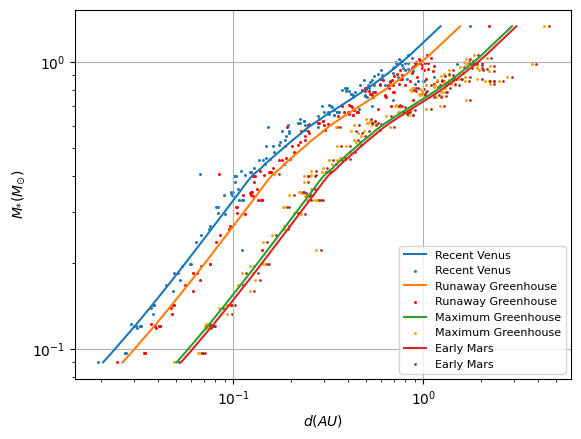

In [108]:
# Graficando Temperatura vs distancias HZ

plt.plot(d_s['lowess_data'][0]['y_smooth'], d_s['lowess_data'][0]['x'],
          label = 'Recent Venus')
plt.scatter(d['Recent_Venus'], Star_mass, label = 'Recent Venus', s = 1.3)

plt.plot(d_s['lowess_data'][1]['y_smooth'], d_s['lowess_data'][1]['x'],
          label = 'Runaway Greenhouse')
plt.scatter(d['Runaway_Greenhouse'], Star_mass, color = 'red', label = 'Runaway Greenhouse', s = 1.3)

plt.plot(d_s['lowess_data'][2]['y_smooth'], d_s['lowess_data'][2]['x'],
          label = 'Maximum Greenhouse')
plt.scatter(d['Max_Greenhouse'], Star_mass, color = 'orange', label = 'Maximum Greenhouse', s = 1.3)

plt.plot(d_s['lowess_data'][3]['y_smooth'], d_s['lowess_data'][3]['x'],
          label = 'Early Mars')
plt.scatter(d['Early_Mars'], Star_mass, color = 'brown', label = 'Early Mars', s = 0.9)
#plt.scatter(d_fivemeRunaway, Star_mass, color = 'green')
#plt.scatter(d_tenthmeRunaway,Star_mass, color= "black")
plt.plot ()
#plt.gca().invert_xaxis()
plt.grid(True)
plt.xlabel(r'$d (AU$)')
plt.ylabel(r'$M_{*}(M_{\odot})$')
plt.xscale("log")
plt.yscale("log")
plt.legend(loc='lower right', fontsize=8)
plt.savefig('Template-Tesis/imágenes/distancias.pdf')
plt.show()

Después de hallar los límites de las zonas habitables, procedemos a ubicar a los planetas que se encuentren dentro de esta zona. Para ello, calcularemos la distancia que hay entre el planeta y su estrella anfitriona.
Sabiendo que la eccentricidad se define como :
$e=\frac{c}{a}$
donde a representa el semi-eje  mayor y c la distancia que hay entre el objeto y su centro y/o foco(estrella). 
Sabiendo que 
* e = 0 -> órbita circular
* e $\epsilon$ [0,1] -> órbita elíptica
* e > 1 -> hipérbola
Entonces, los planetas cuya órbita tenga eccentricidad $e=0$, entonces $a = c$. Si $ e\epsilon\bigr]0;1\bigr]$, entonces $c = ae$.    

In [109]:
a_m = main_stars['Orbit_semimajor_axis']
Planets = main_stars['Planet_name']
e = main_stars['Orbit_eccentricity']


In [110]:
#Calculating distances 
Periapsis = []
Apoapsis = []
for i in range(len(e)):
    if e.iloc[i] == 0 :
        Periapsis.append(a_m.iloc[i])
        Apoapsis.append(a_m.iloc[i])
    elif e.iloc[i] > 0 and e.iloc[i] <=1:
        Periapsis.append(a_m.iloc[i]*(1-e.iloc[i]))
        Apoapsis.append(a_m.iloc[i]*(1+e.iloc[i])) 

print(sorted(Periapsis))

[np.float64(0.00432), np.float64(0.0054), np.float64(0.00747), np.float64(0.008332353), np.float64(0.00841), np.float64(0.00962), np.float64(0.00978), np.float64(0.01), np.float64(0.0112), np.float64(0.01138), np.float64(0.0114939), np.float64(0.01159), np.float64(0.0118), np.float64(0.01195), np.float64(0.01223), np.float64(0.01314), np.float64(0.013596), np.float64(0.01449), np.float64(0.014668), np.float64(0.015), np.float64(0.0153596), np.float64(0.015514739999999997), np.float64(0.0161), np.float64(0.017016), np.float64(0.0171), np.float64(0.017125259599999998), np.float64(0.01723), np.float64(0.017384), np.float64(0.0177), np.float64(0.01796), np.float64(0.01833), np.float64(0.01848), np.float64(0.01859), np.float64(0.0189), np.float64(0.0197), np.float64(0.0203), np.float64(0.02037), np.float64(0.0204), np.float64(0.020752160000000002), np.float64(0.0208), np.float64(0.020861407), np.float64(0.02103), np.float64(0.02122), np.float64(0.02156), np.float64(0.0219), np.float64(0.022

/tmp/ipykernel_27369/3885546612.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(d_s['lowess_data'][0]['y_smooth'], d_s['lowess_data'][0]['x'],
/tmp/ipykernel_27369/3885546612.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(d_s['lowess_data'][1]['y_smooth'], d_s['lowess_data'][1]['x'],
/tmp/ipykernel_27369/3885546612.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(d_s['lowess_data'][2]['y_smoot

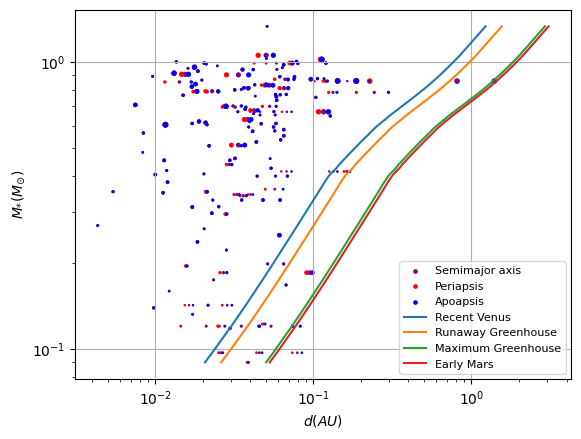

In [115]:

plt.scatter(a_m,Star_mass, color = 'purple', s = main_stars['Planet_mass[Earth]'], label = 'Semimajor axis')
plt.scatter(Periapsis,Star_mass, color = 'red', s = main_stars['Planet_mass[Earth]'],label = 'Periapsis' )
plt.scatter(Apoapsis,Star_mass, color = 'blue', s = main_stars['Planet_mass[Earth]'], label = 'Apoapsis')
plt.plot(d_s['lowess_data'][0]['y_smooth'], d_s['lowess_data'][0]['x'],
          label = 'Recent Venus')
#plt.scatter(d['Recent_Venus'], Star_mass, label = 'Recent Venus')

plt.plot(d_s['lowess_data'][1]['y_smooth'], d_s['lowess_data'][1]['x'],
          label = 'Runaway Greenhouse')
#plt.scatter(d['Runaway_Greenhouse'], Star_mass, color = 'red', label = 'Runaway Greenhouse')

plt.plot(d_s['lowess_data'][2]['y_smooth'], d_s['lowess_data'][2]['x'],
          label = 'Maximum Greenhouse')
#plt.scatter(d['Max_Greenhouse'], Star_mass, color = 'orange', label = 'Maximum Greenhouse')

plt.plot(d_s['lowess_data'][3]['y_smooth'], d_s['lowess_data'][3]['x'],
          label = 'Early Mars')
#plt.scatter(d['Early_Mars'], Star_mass, color = 'brown', label = 'Early Mars')
#plt.scatter(d_fivemeRunaway, Star_mass, color = 'green')
#plt.scatter(d_tenthmeRunaway,Star_mass, color= "black")
plt.plot ()
#plt.gca().invert_xaxis()
plt.grid(True)
plt.xlabel(r'$d (AU$)')
plt.ylabel(r'$M_{*}(M_{\odot})$')
plt.xscale("log")
plt.yscale("log")
plt.legend(loc='lower right', fontsize=8)
plt.savefig('Template-Tesis/imágenes/semiejemayor.pdf')
plt.show()

In [118]:
h_planets_opt = []
h_planets_ = []

# Especifica qué fila del DataFrame usar (por ejemplo, la primera)
row_index = 0  # o el índice que necesites

runaway = d['Runaway_Greenhouse'].iloc[row_index]
recent_venus = d['Recent_Venus'].iloc[row_index]
max_greenhouse = d['Max_Greenhouse'].iloc[row_index]

for h_planet in Planets:
    if recent_venus <= h_planet <= runaway:
        h_planets_opt.append(h_planet)
    elif runaway < h_planet <= max_greenhouse:
        h_planets_.append(h_planet)
    elif max_greenhouse < h_planet <= recent_venus:
        h_planets_opt.append(h_planet)

UFuncTypeError: ufunc 'less_equal' did not contain a loop with signature matching types (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.StrDType'>) -> None

In [119]:
# Classifying planets by distances 
h_planets_opt = []
h_planets_= []
for h_planet in Planets : 
    if  d['Recent_Venus']<=h_planet <= d['Runaway_Greenhouse']   :
        h_planets_opt.append(h_planet)
    elif ['Runaway_Greenhouse']<=h_planet <= d['Max_Greenhouse']:
        h_planets_.append(h_planet)
    elif ['Max_Greenhouse']<=h_planet <= d['Early_Mars']:
        h_planets_opt.append(h_planet)
    else:
        continue


UFuncTypeError: ufunc 'less_equal' did not contain a loop with signature matching types (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.StrDType'>) -> None

In [ ]:
from scipy.stats import describe

des = describe(a_m)

print(des)

DescribeResult(nobs=164, minmax=(np.float64(0.00432), np.float64(0.812)), mean=np.float64(0.052636989957317075), variance=np.float64(0.004912995682176553), skewness=np.float64(8.063081666768175), kurtosis=np.float64(82.62873508390405))


Luego, la distribución de los semiejes major de los planetas que se encuentran dentro de la zona de habitabilidad es 

In [ ]:
# importing pygal

# creating the chart object
histogram = py.Histogram()

# naming the title
histogram.title = 'Histograma de semi eje mayor '        

# Random data
for i in range(5, 20, 10):
    histogram.add(str(i), data)

histogram

AttributeError: module 'pylab' has no attribute 'Histogram'

Ahora bien, determinamos la distribucipon de los semi-ejes mayores con respecto a suu estrella anfitriona. Primero, corrobaremos qué tipo de distribución siguen los datos. Para ello, verificamos gráficamente utilizando quantile, con el fin de determinar si los datos siguen una distribución normal. 

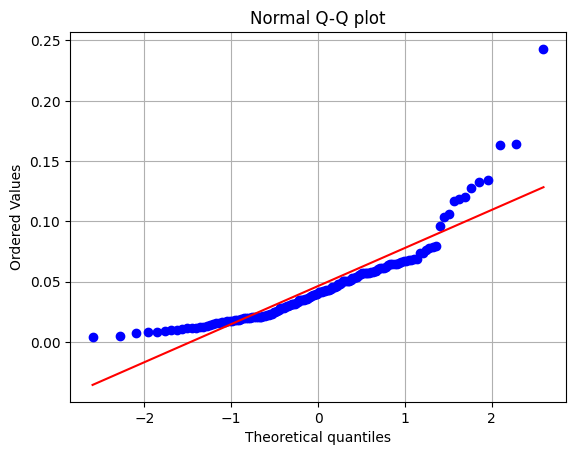

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pylab as py

# Create Q-Q plot
stats.probplot(np.sort(a_m), dist="norm", plot=plt)
plt.title('Normal Q-Q plot')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Ordered Values')
plt.grid(True)
plt.show()


Como se observa en la gráfica los datos no siguen

In [ ]:
# Verificacion de p-value 
from scipy.stats import kstest

res = kstest(a_m, 'norm')

print(res)


KstestResult(statistic=np.float64(0.5017234252907905), pvalue=np.float64(1.5846046936245619e-34), statistic_location=np.float64(0.00432), statistic_sign=np.int8(-1))


In [ ]:
#t-Test
#  
from scipy.stats import ttest_ind

v1 = a_m[:50]
v2 = a_m[51:100]

res = ttest_ind(v1, v2)

print(res)

TtestResult(statistic=np.float64(-0.3114839289175524), pvalue=np.float64(0.7561012268307208), df=np.float64(97.0))


In [ ]:
# Calculando tidal locking  
S_lock = np.linspace(0.1,2,50)
t_lock = (2*np.pii()*Q/2)*(M_p*a**6)/(M*R_p**3*n)

AttributeError: module 'numpy' has no attribute 'pii'